### Pré-processamento ------------------------------------------

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize
import pandas as pd

df = pd.read_csv('./data/diabetes_012_health_indicators_BRFSS2015.csv')

# Selecionar features
features = [
    'HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits',
    'Veggies', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth',
    'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income'
]

target = 'Diabetes_012'

# Colunas que precisam ser escaladas
cols_to_scale = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

# Copiar dataset para pré-processamento
df_processed = df[features + [target]].copy()

# Transformar a variável alvo em binária: 1 para pré-diabetes e diabetes, 0 para sem diabetes
df_processed['Diabetes_012'] =df['Diabetes_012'].replace({2:1})
df_processed = df_processed.rename(columns = {'Diabetes_012': 'Diabetes_binary'})

# Aplicar padronização Z-score nas colunas selecionadas
scaler = StandardScaler()
df_processed[cols_to_scale] = scaler.fit_transform(df_processed[cols_to_scale])
print(df_processed['Diabetes_binary'].value_counts(normalize=True))

# Separar conjuntos para classificação (agora com a variável alvo binária)
X_class = df_processed[features].values
y_class = df_processed['Diabetes_binary'].values # Usar a nova coluna binária

# df_processed['BMI'] = winsorize(df_processed['BMI'], limits=[0.01, 0.01])

# Separar treino e teste (somente para classificação)
X_train, X_test, y_train, y_test = train_test_split(
    X_class, y_class, test_size=0.3, random_state=42, stratify=y_class
)

Diabetes_binary
0.0    0.842412
1.0    0.157588
Name: proportion, dtype: float64


In [2]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Aplicar SMOTE ao conjunto de treino
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Verificar nova distribuição
unique, counts = np.unique(y_resampled, return_counts=True)
for cls, count in zip(unique, counts):
    pct = count / sum(counts) * 100
    print(f'Classe {cls}: {count} exemplos ({pct:.2f}%)')

Classe 0.0: 149592 exemplos (50.00%)
Classe 1.0: 149592 exemplos (50.00%)


### Feature Selection

[Text(0, 0, 'HighBP'),
 Text(1, 0, 'HighChol'),
 Text(2, 0, 'BMI'),
 Text(3, 0, 'Smoker'),
 Text(4, 0, 'Stroke'),
 Text(5, 0, 'HeartDiseaseorAttack'),
 Text(6, 0, 'PhysActivity'),
 Text(7, 0, 'Fruits'),
 Text(8, 0, 'Veggies'),
 Text(9, 0, 'HvyAlcoholConsump'),
 Text(10, 0, 'GenHlth'),
 Text(11, 0, 'MentHlth'),
 Text(12, 0, 'PhysHlth'),
 Text(13, 0, 'DiffWalk'),
 Text(14, 0, 'Sex'),
 Text(15, 0, 'Age'),
 Text(16, 0, 'Education'),
 Text(17, 0, 'Income')]

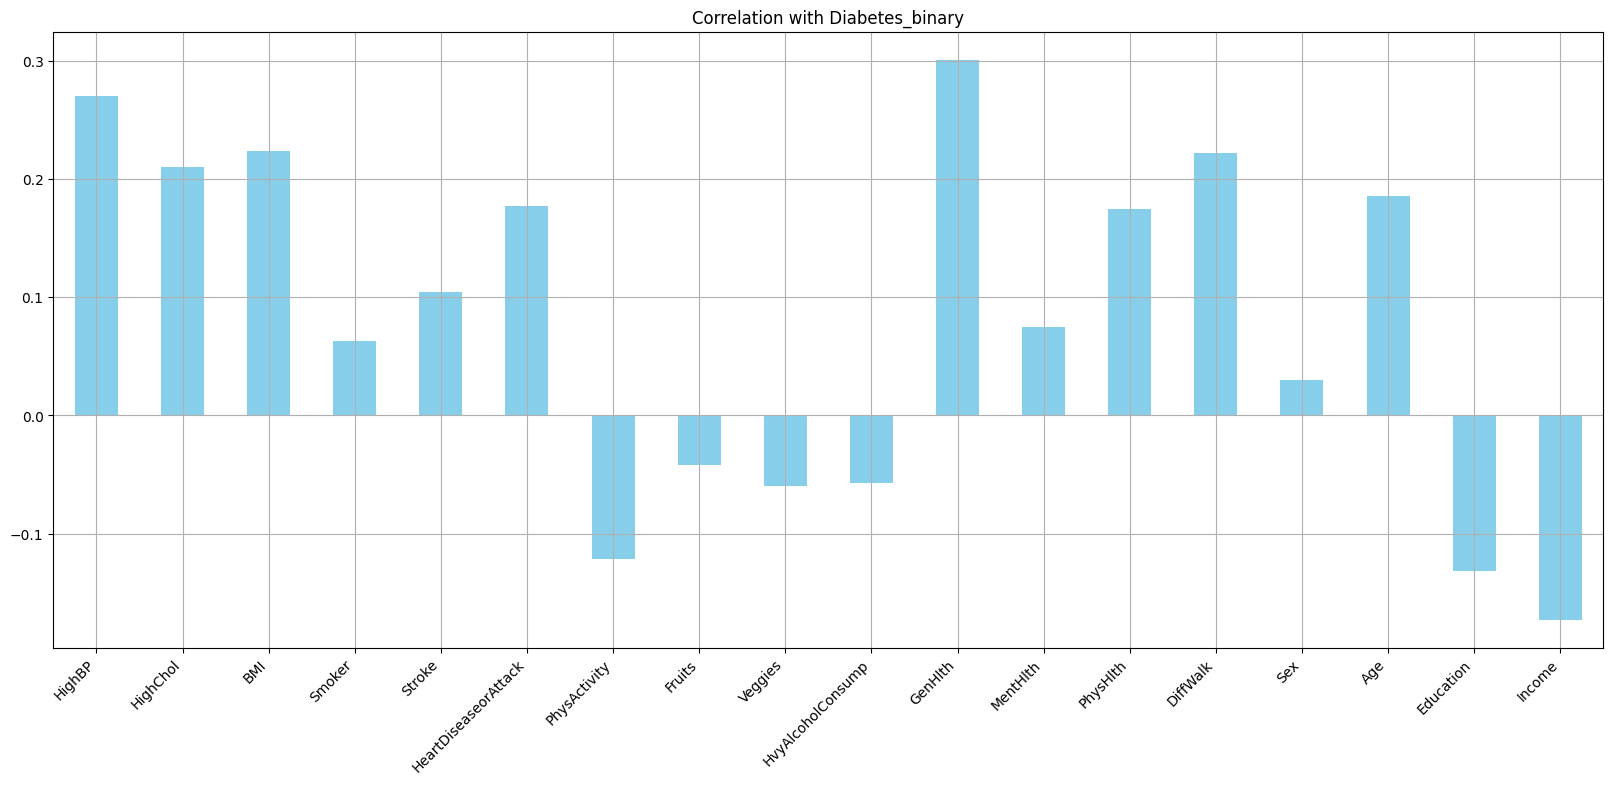

In [3]:
ax = df_processed.drop('Diabetes_binary', axis=1).corrwith(df_processed.Diabetes_binary).plot(
    kind='bar', grid=True, figsize=(20, 8), title="Correlation with Diabetes_binary", color="skyblue"
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

In [4]:
from sklearn.feature_selection import SelectKBest, chi2

# Usar as features originais (não padronizadas) para o teste chi2
X_chi2 = df[features]
y_chi2 = df_processed['Diabetes_binary']

# Calcular o chi2 entre as features e a variável alvo binária
chi2_scores, p_values = chi2(X_chi2, y_chi2)

# Exibir resultados em um DataFrame ordenado pelo score
chi2_df = pd.DataFrame({'Feature': features, 'Score': chi2_scores, 'p-value': p_values})
chi2_df = chi2_df.sort_values('Score', ascending=False)
print(chi2_df.nlargest(16,'Score'))

                 Feature          Score        p-value
12              PhysHlth  139108.716691   0.000000e+00
11              MentHlth   24601.500440   0.000000e+00
2                    BMI   19560.690483   0.000000e+00
0                 HighBP   10585.790180   0.000000e+00
10               GenHlth   10433.067217   0.000000e+00
13              DiffWalk   10413.686810   0.000000e+00
15                   Age   10180.585970   0.000000e+00
5   HeartDiseaseorAttack    7193.573093   0.000000e+00
1               HighChol    6460.310201   0.000000e+00
17                Income    5366.985070   0.000000e+00
4                 Stroke    2673.124819   0.000000e+00
6           PhysActivity     910.094531  6.271977e-200
16             Education     847.937402  2.041644e-186
9      HvyAlcoholConsump     769.246163  2.622181e-169
3                 Smoker     556.698680  4.393097e-123
8                Veggies     167.767244   2.274265e-38


In [5]:
# Selecionar as 16 melhores características baseadas no chi2
top_16_features = chi2_df.nlargest(16, 'Score')['Feature'].tolist()
print("Top 16 características selecionadas:")
print(top_16_features)

# Criar novos datasets com apenas as 16 melhores características
X_top16 = df[top_16_features]
y_top16 = df_processed['Diabetes_binary']

# Dividir os dados
from sklearn.model_selection import train_test_split
X_train_top16, X_test_top16, y_train_top16, y_test_top16 = train_test_split(
    X_top16, y_top16, test_size=0.3, random_state=42, stratify=y_top16
)

print(f"\nShape dos dados de treino: {X_train_top16.shape}")
print(f"Shape dos dados de teste: {X_test_top16.shape}")

Top 16 características selecionadas:
['PhysHlth', 'MentHlth', 'BMI', 'HighBP', 'GenHlth', 'DiffWalk', 'Age', 'HeartDiseaseorAttack', 'HighChol', 'Income', 'Stroke', 'PhysActivity', 'Education', 'HvyAlcoholConsump', 'Smoker', 'Veggies']

Shape dos dados de treino: (177576, 16)
Shape dos dados de teste: (76104, 16)


In [6]:
# Identificar tipos de características para preprocessamento
# Características binárias (0/1)
binary_features_top16 = ['HighBP', 'HighChol', 'HeartDiseaseorAttack', 'Stroke', 
                         'DiffWalk', 'PhysActivity', 'HvyAlcoholConsump', 'Smoker', 'Veggies']

# Características categóricas ordinais
categorical_features_top16 = ['GenHlth', 'Education', 'Income', 'Age']

# Características numéricas contínuas
numerical_features_top16 = ['BMI', 'PhysHlth', 'MentHlth']

print("Características binárias:", len(binary_features_top16))
print("Características categóricas:", len(categorical_features_top16)) 
print("Características numéricas:", len(numerical_features_top16))
print("Total:", len(binary_features_top16) + len(categorical_features_top16) + len(numerical_features_top16))

# Criar pipeline de preprocessamento para as 16 características
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Apenas as características numéricas precisam ser escalonadas para KNN
preprocessor_top16 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_top16),
        ('bin', 'passthrough', binary_features_top16),
        ('cat', 'passthrough', categorical_features_top16)
    ])

# Aplicar o preprocessamento
X_train_top16_processed = preprocessor_top16.fit_transform(X_train_top16)
X_test_top16_processed = preprocessor_top16.transform(X_test_top16)

print(f"\nShape após preprocessamento:")
print(f"Treino: {X_train_top16_processed.shape}")
print(f"Teste: {X_test_top16_processed.shape}")

Características binárias: 9
Características categóricas: 4
Características numéricas: 3
Total: 16

Shape após preprocessamento:
Treino: (177576, 16)
Teste: (76104, 16)


In [7]:
# Treinar modelo KNN com as 16 melhores características
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Definir parâmetros para grid search
param_grid_knn_top16 = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Criar modelo KNN
knn_top16 = KNeighborsClassifier()

# Grid search com validação cruzada
print("Iniciando Grid Search para KNN com 16 características...")
grid_search_knn_top16 = GridSearchCV(
    knn_top16, 
    param_grid_knn_top16, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Treinar o modelo
grid_search_knn_top16.fit(X_train_top16_processed, y_train_top16)

print(f"\nMelhores parâmetros: {grid_search_knn_top16.best_params_}")
print(f"Melhor score de validação cruzada: {grid_search_knn_top16.best_score_:.4f}")

# Obter o melhor modelo
best_knn_top16 = grid_search_knn_top16.best_estimator_

Iniciando Grid Search para KNN com 16 características...
Fitting 5 folds for each of 28 candidates, totalling 140 fits

Melhores parâmetros: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'uniform'}
Melhor score de validação cruzada: 0.8458


Acurácia no conjunto de teste (16 características): 0.8455
Acurácia no conjunto de treino (16 características): 0.8551

Relatório de Classificação - TESTE:
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     64111
         1.0       0.53      0.16      0.25     11993

    accuracy                           0.85     76104
   macro avg       0.70      0.57      0.58     76104
weighted avg       0.81      0.85      0.81     76104


Relatório de Classificação - TREINO:
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92    149592
         1.0       0.63      0.19      0.30     27984

    accuracy                           0.86    177576
   macro avg       0.75      0.59      0.61    177576
weighted avg       0.83      0.86      0.82    177576


Matriz de Confusão - TESTE:
[[62428  1683]
 [10075  1918]]

Matriz de Confusão - TREINO:
[[146462   3130]
 [ 22599   5385]]


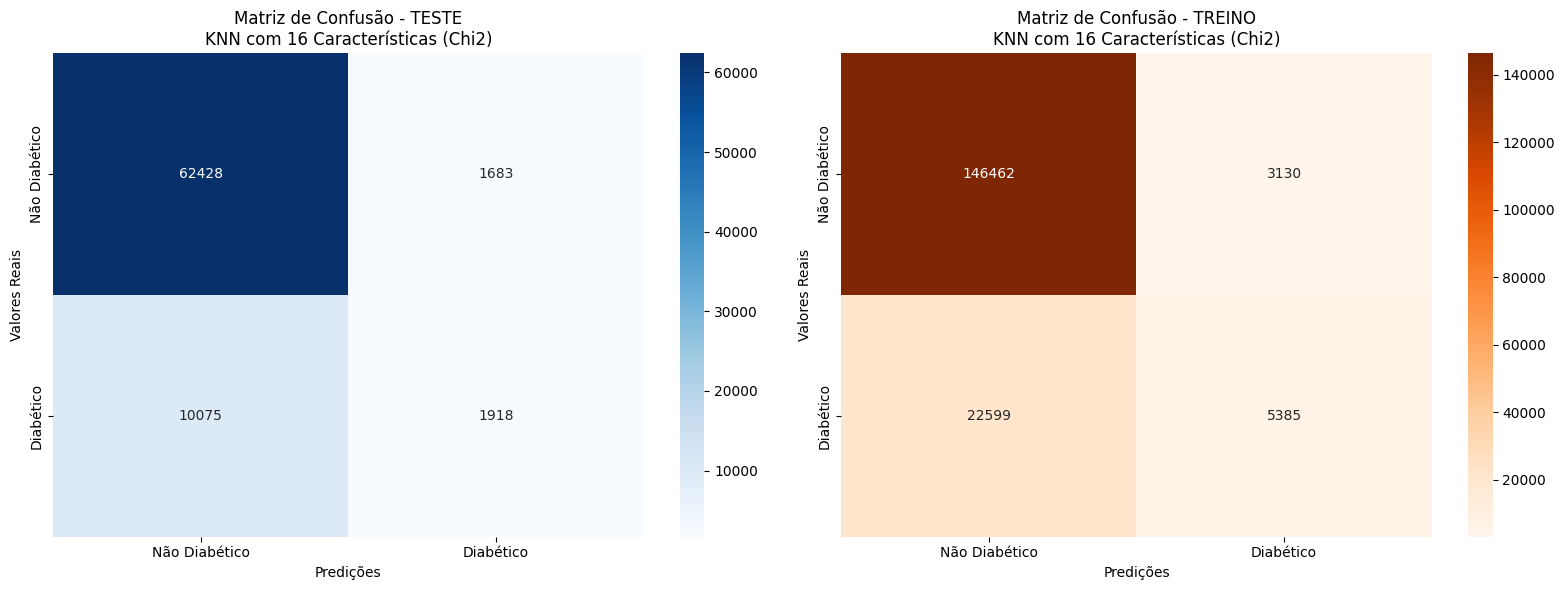


=== COMPARAÇÃO DE RESULTADOS ===
KNN com 16 características (Chi2) - Teste: 0.8455
KNN com 16 características (Chi2) - Treino: 0.8551
Diferença (Treino - Teste): 0.0096


In [9]:
# Avaliar o modelo no conjunto de teste
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Fazer predições no conjunto de teste
y_pred_knn_top16 = best_knn_top16.predict(X_test_top16_processed)

# Fazer predições no conjunto de treino
y_pred_train_knn_top16 = best_knn_top16.predict(X_train_top16_processed)

# Calcular métricas para teste
accuracy_top16 = accuracy_score(y_test_top16, y_pred_knn_top16)
print(f"Acurácia no conjunto de teste (16 características): {accuracy_top16:.4f}")

# Calcular métricas para treino
accuracy_train_top16 = accuracy_score(y_train_top16, y_pred_train_knn_top16)
print(f"Acurácia no conjunto de treino (16 características): {accuracy_train_top16:.4f}")

# Relatório de classificação para teste
print("\nRelatório de Classificação - TESTE:")
print(classification_report(y_test_top16, y_pred_knn_top16))

# Relatório de classificação para treino
print("\nRelatório de Classificação - TREINO:")
print(classification_report(y_train_top16, y_pred_train_knn_top16))

# Matriz de confusão para teste
cm_knn_top16 = confusion_matrix(y_test_top16, y_pred_knn_top16)
print(f"\nMatriz de Confusão - TESTE:")
print(cm_knn_top16)

# Matriz de confusão para treino
cm_train_knn_top16 = confusion_matrix(y_train_top16, y_pred_train_knn_top16)
print(f"\nMatriz de Confusão - TREINO:")
print(cm_train_knn_top16)

# Plotar matrizes de confusão
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de confusão - Teste
sns.heatmap(cm_knn_top16, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Não Diabético', 'Diabético'], 
            yticklabels=['Não Diabético', 'Diabético'], ax=axes[0])
axes[0].set_title('Matriz de Confusão - TESTE\nKNN com 16 Características (Chi2)')
axes[0].set_ylabel('Valores Reais')
axes[0].set_xlabel('Predições')

# Matriz de confusão - Treino
sns.heatmap(cm_train_knn_top16, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Não Diabético', 'Diabético'], 
            yticklabels=['Não Diabético', 'Diabético'], ax=axes[1])
axes[1].set_title('Matriz de Confusão - TREINO\nKNN com 16 Características (Chi2)')
axes[1].set_ylabel('Valores Reais')
axes[1].set_xlabel('Predições')

plt.tight_layout()
plt.show()

# Comparar com resultados anteriores se disponível
print(f"\n=== COMPARAÇÃO DE RESULTADOS ===")
print(f"KNN com 16 características (Chi2) - Teste: {accuracy_top16:.4f}")
print(f"KNN com 16 características (Chi2) - Treino: {accuracy_train_top16:.4f}")
print(f"Diferença (Treino - Teste): {accuracy_train_top16 - accuracy_top16:.4f}")
